# `qubit_discovery` Overview

This notebook will guide you through using the core features of the `qubit_discovery` module, and show you how to put them together to optimize a fluxonium circuit using BFGS.

Much of the heavy lifting here is done by [`SQcircuit`](https://sqcircuit.org/), a package for simulating superconducting circuits and calculating gradients using the [`PyTorch`](https://pytorch.org/) package. The `qubit_discovery` modules lays on top and provides a set of utilities to quickly begin optimization. Before reading this tutorial, familiarize yourself with the basic features of `SQcircuit` [here](https://docs.sqcircuit.org/).

In [1]:
import SQcircuit as sq
import qubit_discovery as qd

# Switch to the PyTorch engine to support gradient and optimization
sq.set_engine('PyTorch')

## Circuit utilities 

### Sampling

Optimization begins by choosing a random starting point. The `CircuitSampler` class makes this easy to do based on a range of element values you want to sample between. To match the paper [TODO], let's set the allowable element ranges to:

| Element type       | Minimum value | Maximum value |
|--------------------|---------------|---------------|
| Capacitor          | 1 fF          | 12 pF         |
| Inductor           | 1 fH          | 5 µH          |
| Josephson junction | 1 GHz         | 100 GHz       |

Currently `CircuitSampler` only supports circuits with a single inductive loop. However, you can optimize over the external flux through it by passing in an allowed flux range $\subset [0, 1]$. Since the Hamiltonian will be symmetric about $\varphi_\text{ext} = 0.5$, we optimize over the range $[0, 0.5]$.

In [2]:
from qubit_discovery.optimization import CircuitSampler

# Set up a sampler
sampler = CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0, 0.5]                 # in units of Phi_0        
)

The topology of the circuit to be sampled is specified by string called a "**circuit code**." In the case of single-loop circuits, this is a list of the inductive elements present in the loop (`'J'` for Josephson junction and `'L`' for inductor); a more detailed description can be found in the paper [TODO].

For instance, a fluxonium has the circuit code `'JL'`.

In [3]:
# Randomly sample a circuit from the element ranges above…
fluxonium = sampler.sample_circuit_code('JL')
# …and print out the description.
fluxonium.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Truncating circuits

To numerically simulate the circuit, the infinite-dimensional Hamiltonian must be truncated. In `SQcircuit`, this is done by choosing truncation numbers for each circuit mode.

Fluxonium and transmon circuits have a single mode, so all you have to do is pick a sufficiently large truncation number.

In contrast, for circuits with multiples modes, it can be difficult to decide how choose truncation numbers. For instance, let's consider a `'JLL'` circuit, which has two harmonic modes.

<center><img src="figs/jll_overview.png" width="240" height="240"></center>

In [4]:
# Here, we build the circuit by hand so you can get the same results, but feel
# free to try a random one instead by using `circuit = sampler.sample_circuit_code('JLL')`.
loop = sq.Loop(0.35)
circuit = sq.Circuit(
    {
        (0, 1): [sq.Junction(61, 'GHz', loops=[loop]), sq.Capacitor(4e-13, 'F')],
        (1, 2): [sq.Inductor(5e-9, 'H', loops=[loop]), sq.Capacitor(4e-13, 'F')],
        (2, 0): [sq.Inductor(1e-9, 'H', loops=[loop]), sq.Capacitor(1e-13, 'F')],
    },
    flux_dist='junctions'
)
circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As you can see, the first mode has a higher characteristic frequency, so will participate less strongly in the low-energy states of the circuit. 

During optimization, we want to constrain the time and memory it takes to diagonalize by fixing a maximum Hilbert space dimension $K$. Without prior knowledge of the circuit, the only reasonable solution is to assign each of the modes of the circuit a truncation number $K^{1/2}$ (so that the total tensor-product Hilbert space has dimension $K$).

In [5]:
K = 700
circuit.set_trunc_nums([int(K**(1/2)), int(K**(1/2))]) # circuit.truncate_circuit(K) is a shortcut for this
print('Truncation numbers', circuit.trunc_nums)

circuit.diag(10)
# t is a parameter to chose stringency to check convergence; see the SQcircuit docs
print('Is the circuit converged?', circuit.check_convergence(t=5)) 

Truncation numbers [26, 26]
Is the circuit converged? (False, 0.012903336442181224)


The `qubit_discovery` module offers a function `assign_trunc_nums` which analyzes the circuit to understand which modes are important for the low-energy states, and preferentially assign higher truncation numbers to those modes. It takes in a desired total truncation number (maximum Hilbert space size) $K$ and uses a heuristic method to decide how to allocate truncation numbers to each mode. 

Using this function, circuits can be accurately simulated with a lower $K$ than when assigning each mode an equal truncation number.

In [7]:
qd.optimization.assign_trunc_nums(circuit, total_trunc_num=K)

print('New truncation numbers', circuit.trunc_nums)

circuit.diag(10)
print('Is the circuit converged?', circuit.check_convergence(t=5)) 

New truncation numbers [9, 77]
Is the circuit converged? (True, 8.368921566193066e-06)


Notice that the `assign_trunc_nums` decided (just as we did by looking at the characteristic frequencies of each mode) that the first mode was less important, and assigned it a smaller truncation number (7 versus 100).

For an explanation of how the optimal truncation numbers are chosen, see Appendix E of our paper, [TODO]. For an explanation of how `check_convergence` works, see Appendix D.

## Constructing a loss function

A loss function is built out of a number of component metrics you want to optimize for. The `qubit_discovery.losses` module offers a number of pre-built metrics, which can be accessed with the `get_all_metrics()` function.

In [8]:
qd.losses.get_all_metrics()

['frequency',
 'flux_sensitivity',
 'charge_sensitivity',
 'number_of_gates',
 'anharmonicity',
 'element_sensitivity',
 'gate_speed',
 't2',
 't1',
 't1_capacitive',
 't1_inductive',
 't1_quasiparticle',
 't_phi',
 't_phi_charge',
 't_phi_cc',
 't_phi_flux']

All the metrics functions are available in the `ALL_METRICS` dictionary; call `help()` on any of them for more details about what a particular metric/loss is.

In [9]:
help(qd.losses.ALL_METRICS['anharmonicity'])

Help on function anharmonicity_loss in module qubit_discovery.losses.loss:

anharmonicity_loss(circuit: SQcircuit.circuit.Circuit) -> Tuple[Union[float, torch.Tensor], Union[float, torch.Tensor]]
    Computes a loss to penalize low anharmonicitiy. The absolute anharmonicity is
        ``A = omega_{21} - omega_{10}``
    and the relative anharmonicity is
        ``Ar = (omega_{21} - omega_{10})/omega_{10}``.

    Parameters
    ----------
        circuit:
            A ``Circuit`` object specifying the qubit.

    Returns
    ----------
        loss:
            1 / Ar, the reciprocal of the relative anharmonicity.
        anharmonicity:
            A, the absolute anharmonicity.



After deciding the metrics you want to optimize for, you can build a loss function using the `build_loss_function` constructor. This takes in two inputs:
1. The list of metrics you want to optimize for, and the weights in the loss function. The total loss function is then constructed as

$$ \mathcal{L}_\text{tot} = \sum_\text{metrics} \text{weight} \times \mathcal{L}_\text{metric} $$

2. A list of other metrics you want to track during optimization. (For instance, you may only want to optimize for $T_2$ time, but still track what the qubit frequency is.)

Each metric is identified by a name, provided by `get_all_metrics()`.

Below, we'll build a loss function which optimizes for low charge sensitivity, low flux sensitivity, and a large number of single-qubit gates, for simplicity all with the same weight. We'll also track a lot of other properties: $T_1$, $T_\varphi$, $T_2$, the anharmonicity $\alpha$, and $\omega_{01}$.

In [10]:
my_loss_function = qd.losses.build_loss_function(
    use_losses = { # use_losses is a dictionary of metric: weight
        'flux_sensitivity': 1.0,
        'number_of_gates': 1.0
    },
    use_metrics = [ # use_losses is a list of metrics to track
        't1', 
        't_phi',
        't2',
        'anharmonicity',
        'frequency'
    ]
)

## Performing optimization

Now that we've sampled a random circuit and built our loss function, we can perform optimization. Currently, `qubit_discovery` offers two ready-built algorithms: gradient descent and BFGS. These algorithms internally implement the truncation procedures described above.

BFGS performs better for most loss functions, so we'll perform optimization using it. We run it by calling `run_BFGS`. SGD can be run with `run_SGD`, which has the same call signature.

We pass in a maximum number of iterations to perform (25), but the BFGS algorithm automatically terminates when it reaches a local optima, so don't worry if it stops early.

In [11]:
initial_circuit = sampler.sample_circuit_code('JL')
initial_circuit.element_description()

optim_result = qd.optimization.run_BFGS(
    circuit=initial_circuit,                    # Starting point
    loss_metric_function=my_loss_function,      # Loss function to optimize
    max_iter=25,                                # Maximum number of iterations
    total_trunc_num=200,                        # Total truncation numbers
    bounds=sampler.bounds                       # Bounds to keep the circuit within during optimization.
)

Edge (0, 1):
	JJ = 1.207e+11 Hz
	L = 9.243e-10 H
	C = 2.229e-15 F



Iteration 8:  32%|███▏      | 8/25 [00:25<00:54,  3.22s/it, loss=6.157e-06]


The result has the optimized circuit, so we can check what the new element values are:

In [12]:
optim_result.circuit.element_description()

Edge (0, 1):
	JJ = 2.077e+11 Hz
	L = 2.329e-06 H
	C = 1.401e-15 F



It also has a record of all the losses and metrics for each step of optimization. Let's plot those.

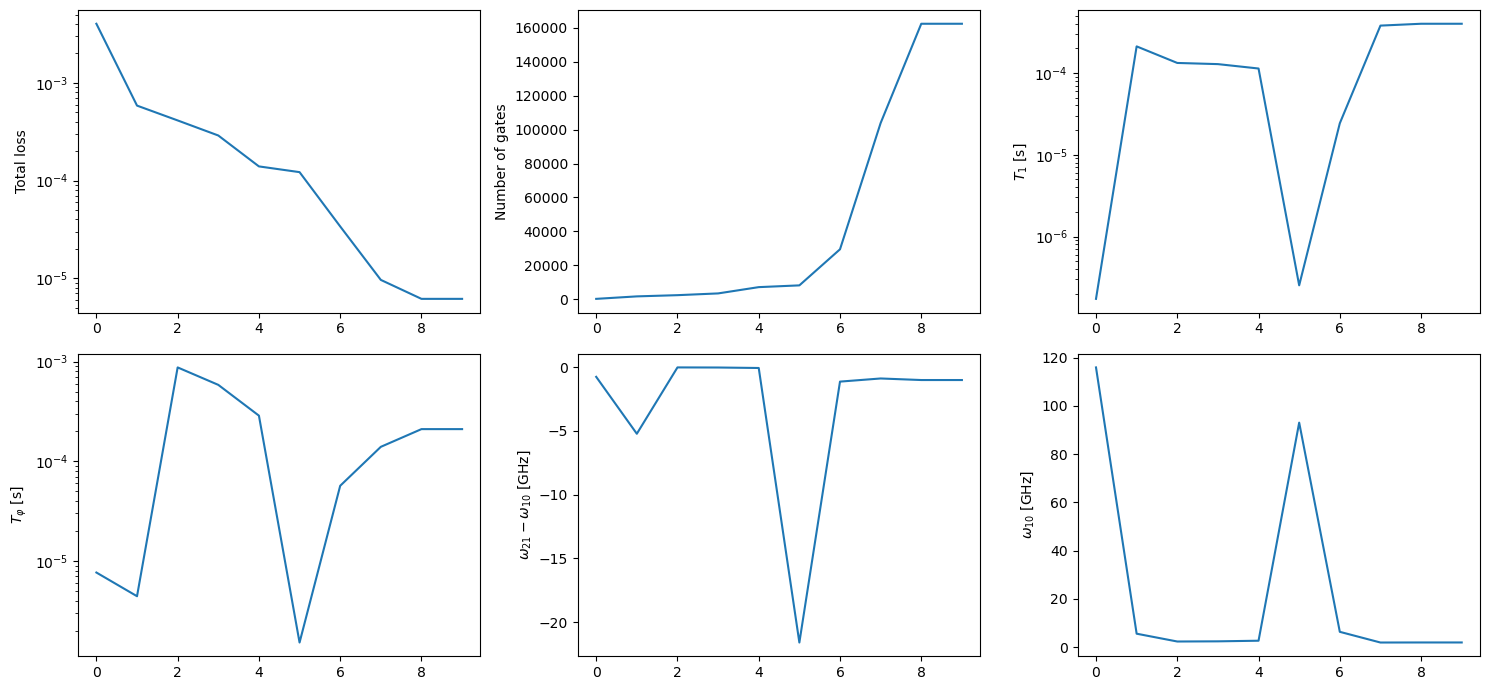

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

axs[0, 0].semilogy(optim_result.record['total_loss'])
axs[0, 0].set_ylabel('Total loss')
axs[0,1].plot(optim_result.record['number_of_gates'])
axs[0, 1].set_ylabel('Number of gates')
axs[0, 2].semilogy(optim_result.record['t1'])
axs[0, 2].set_ylabel(r'$T_1$ [s]')
axs[1, 0].semilogy(optim_result.record['t_phi'])
axs[1, 0].set_ylabel(r'$T_\varphi$ [s]')
axs[1, 1].plot(optim_result.record['anharmonicity'])
axs[1, 1].set_ylabel(r'$\omega_{21} - \omega_{10}$ [GHz]')
axs[1, 2].plot(optim_result.record['frequency'])
axs[1, 2].set_ylabel(r'$\omega_{10}$ [GHz]')

fig.tight_layout()